In [1]:
import os
import csv
import re
import pandas as pd
import numpy as np

In [2]:
# 载入数据,分离数据集与标签
white_dataset = pd.read_csv(r'data/winequality-white.csv', sep='/')
white_dataset = np.array(white_dataset['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";' \
                               '"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol"' \
                               ';"quality"'].str.split(';', expand=True).astype(float))
white_label = white_dataset[:,11]
white_data = white_dataset[:,:11]

In [3]:
from collections import Counter
# 已知共有6类
classes = dict(Counter(white_label))
print(classes)

# 扩展标签
classname = np.unique(white_label)
print(classname)
multi_white_label = np.zeros([len(white_label),len(classname)])
for i in range(len(classname)):
    multi_white_label[np.where(white_label==classname[i]),i] = 1
print(multi_white_label)

{6.0: 2198, 5.0: 1457, 7.0: 880, 8.0: 175, 4.0: 163, 3.0: 20, 9.0: 5}
[3. 4. 5. 6. 7. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
# 类平均向量mc
mc = np.zeros([7,len(white_data[0])])
mc_num = np.zeros([7,1])
for i in range(len(white_label)):
    if white_label[i] == 3.0:
        mc[0] += white_data[i]
        mc_num[0] += 1
        continue
    if white_label[i] == 4.0:
        mc[1] += white_data[i]
        mc_num[1] += 1
        continue
    if white_label[i] == 5.0:
        mc[2] += white_data[i]
        mc_num[2] += 1
        continue
    if white_label[i] == 6.0:
        mc[3] += white_data[i]
        mc_num[3] += 1
        continue
    if white_label[i] == 7.0:
        mc[4] += white_data[i]
        mc_num[4] += 1
        continue
    if white_label[i] == 8.0:
        mc[5] += white_data[i]
        mc_num[5] += 1
        continue
    if white_label[i] == 9.0:
        mc[6] += white_data[i]
        mc_num[6] += 1
        continue
for i in range(len(mc_num)):
    mc[i] /= mc_num[i]
print(mc)

[[7.60000000e+00 3.33250000e-01 3.36000000e-01 6.39250000e+00
  5.43000000e-02 5.33250000e+01 1.70600000e+02 9.94884000e-01
  3.18750000e+00 4.74500000e-01 1.03450000e+01]
 [7.12944785e+00 3.81226994e-01 3.04233129e-01 4.62822086e+00
  5.00981595e-02 2.33588957e+01 1.25279141e+02 9.94276687e-01
  3.18288344e+00 4.76134969e-01 1.01524540e+01]
 [6.93397392e+00 3.02010981e-01 3.37652711e-01 7.33496911e+00
  5.15463281e-02 3.64320522e+01 1.50904598e+02 9.95262570e-01
  3.16883322e+00 4.82203157e-01 9.80884008e+00]
 [6.83767061e+00 2.60564149e-01 3.38025478e-01 6.44160601e+00
  4.52174704e-02 3.56505914e+01 1.37047316e+02 9.93961349e-01
  3.18859873e+00 4.91105551e-01 1.05753715e+01]
 [6.73471591e+00 2.62767045e-01 3.25625000e-01 5.18647727e+00
  3.81909091e-02 3.41255682e+01 1.25114773e+02 9.92452398e-01
  3.21389773e+00 5.03102273e-01 1.13679356e+01]
 [6.65714286e+00 2.77400000e-01 3.26514286e-01 5.67142857e+00
  3.83142857e-02 3.67200000e+01 1.26165714e+02 9.92235943e-01
  3.21868571e+00

In [5]:
# 总平均向量m_white
m_white = np.zeros(len(white_data[0]))
for i in range(len(white_data[0])):
    m_white[i] = white_data[:, i].mean()
print(m_white)

[6.85478767e+00 2.78241119e-01 3.34191507e-01 6.39141486e+00
 4.57723561e-02 3.53080849e+01 1.38360657e+02 9.94027376e-01
 3.18826664e+00 4.89846876e-01 1.05142670e+01]


In [6]:
# 构建Sw,Sb，ST
Sw = np.zeros([11,11])
for i in range(7):
    for j in range(len(white_label)):
        if white_label[j] == i + 3.0:
            temp = white_data[j] - mc[i]
            Sw += np.outer(temp ,temp.T)
# print(Sw)
print(Sw.shape)
Sb = np.zeros([11,11])
for i in range(7):
    temp = mc[i] - m_white[i]
    Sb += mc_num[i] * np.outer(temp, temp.T)
# print(Sb)
print(Sb.shape)
ST = Sw + Sb

(11, 11)
(11, 11)


In [7]:
# 求解投影方向
w = np.linalg.eig(np.linalg.pinv(Sw)*Sb)[1][0:8]
print(w)

[[ 5.63355806e-04  1.18139461e-03 -1.38304397e-03  4.41024716e-03
  -3.41101829e-02 -9.56600834e-02 -3.18302163e-01  9.39773175e-01
  -1.32586186e-02  6.87146114e-02 -1.65888917e-02]
 [ 4.84821285e-04 -2.49485176e-02 -9.53434715e-01 -1.48669362e-01
  -2.54701117e-01  5.70670443e-02  8.92304137e-03 -8.36207580e-04
  -3.24808428e-03 -4.09991737e-03 -1.26101650e-04]
 [ 3.49197309e-04 -2.15777641e-02 -2.92223172e-01  4.17803733e-01
   8.58829743e-01  3.24481112e-02 -1.36228709e-02  2.73858392e-02
  -7.66294477e-04  1.12013322e-03 -1.05810011e-03]
 [ 2.86582377e-04  2.89826941e-04  1.70646607e-03  1.84602333e-03
  -1.09620568e-03 -1.75048965e-02 -1.13823234e-01  3.41114469e-02
   1.11038859e-01 -9.85252120e-01  5.01518043e-02]
 [ 4.81207911e-03  9.99389842e-01 -2.94876281e-02  1.73620168e-03
   1.37899211e-02  1.08753818e-02 -3.80741782e-03 -1.02798306e-03
  -3.08558205e-04  4.05021718e-04 -6.82274626e-05]
 [ 3.87428138e-06  1.92196421e-05  9.42585295e-04  3.28692511e-04
   6.59222633e-04  

[[-5.75366734e+01  6.35901885e-01  7.73918673e+00 ...  9.18034045e+00
   3.31711890e+00 -7.24261350e+00]
 [-4.25798516e+01  1.38307397e+00 -7.21816372e-01 ...  9.27325293e+00
   4.52908567e+00 -6.41033396e+00]
 [-3.29574146e+01  1.14006182e+00  2.47226913e+00 ...  9.47732824e+00
   5.08984337e+00 -8.25012512e+00]
 ...
 [-3.74249740e+01  2.31602098e+00 -4.50906793e-02 ...  9.06807805e+00
   4.42304443e+00 -6.65413761e+00]
 [-3.62206784e+01  1.64828933e+00 -4.51680483e-01 ...  1.21146299e+01
   5.95872592e+00 -5.61974706e+00]
 [-3.25793476e+01  1.62705198e+00 -3.70773709e-01 ...  1.10721154e+01
   5.68981879e+00 -6.12100935e+00]]


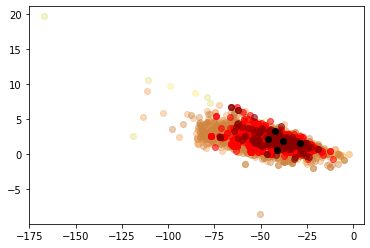

In [8]:
# LDA降维与可视化
import matplotlib.pyplot as plt
white_data_lda = np.dot(white_data, w.T)
print(white_data_lda)


color = ['y', 'gold', 'sandybrown', 'peru', 'red', 'darkred', 'k']
alpha = [0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 1]
for i, c, a in zip(classname, color, alpha):
    plt.scatter(white_data_lda[np.where(white_label==i), 0], white_data_lda[np.where(white_label==i), 1], c=c, alpha=a)
plt.show()

In [9]:
# from sklearn import preprocessing
# # 数据归一化
# white_data_lda_norm = preprocessing.minmax_scale(white_data_lda ,feature_range=(-1, 1), axis=0, copy=True)
# color = ['y', 'gold', 'sandybrown', 'peru', 'red', 'darkred', 'k']
# alpha = [0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 1]
# for i, c, a in zip(classname, color, alpha):
#     plt.scatter(white_data_lda_norm[np.where(white_label==i), 0], white_data_lda_norm[np.where(white_label==i), 1], c=c, alpha=a)
# plt.show()

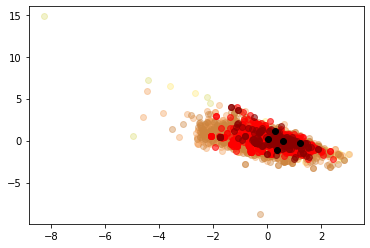

In [10]:
# 朴素数据归一化
s = np.std(white_data_lda, axis=0)
m_white_norm = np.zeros(len(white_data_lda[0]))
for i in range(len(white_data_lda[0])):
    m_white_norm[i] = white_data_lda[:, i].mean(0)
white_data_lda_norm = (white_data_lda - m_white_norm)/s
color = ['y', 'gold', 'sandybrown', 'peru', 'red', 'darkred', 'k']
alpha = [0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 1]
for i, c, a in zip(classname, color, alpha):
    plt.scatter(white_data_lda_norm[np.where(white_label==i), 0], white_data_lda_norm[np.where(white_label==i), 1], c=c, alpha=a)
plt.show()

In [11]:
# softmax判断函数
def softmax(w, b, x):
    s = np.exp(np.dot(w, x.reshape(x.shape[0],1)) + b)
    return s/s.sum()

In [12]:
import math
# 梯度计算函数
def gradient(w, b, x, multi_label):
    gradient_w = np.zeros([7, len(x[0])])
    gradient_b = np.zeros([7, 1])
    for i in range(len(x)):
        J = softmax(w, b, x[i])
        for j in range(7):
            gradient_w[j] += x[i] * (multi_label[i,j] - J[j])
            gradient_b[j] += multi_label[i,j] - J[j] 
    return gradient_w/len(x), gradient_b/len(x)

In [13]:
import time
# logistics回归函数
def logistics_classification(w, b, ita, delta, maxiter, data, label):
    iteration = 0
    w_ = w
    b_ = b
    time_start = time.time()
    while(True):
        gradient_w, gradient_b = gradient(w_, b_, data, label)
        w_ += ita * gradient_w
        b_ += ita * gradient_b
#         if iteration%100 == 0:
#             print("iteration: %d ,w = " %iteration)
#             print(w_)
        iteration += 1
        if np.linalg.norm(gradient_w) < delta or iteration >= maxiter:
            break
    time_end = time.time()
    print('%s  %f s' % ("训练耗时为", (time_end - time_start)))
    return w_, b_

In [14]:
# 对原数据进行logistics回归分类
w0 = np.zeros([7, len(white_data[0])])
b0 = np.zeros([7, 1])
ita = 1e-5
delta = 0.05
maxiter = 1000
w0, b0 = logistics_classification(w0, b0, ita, delta, maxiter, white_data, multi_white_label)

训练耗时为  31.593090 s


In [15]:
# 5重交叉验证
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [16]:
# 对降维后的数据进行logistic回归分类
# 使用交叉验证，记录每次学习得到的w和b

w_stack = []
b_stack = []
acc_stack = []
ford = 1
for X_train_i,X_test_i in kf.split(white_data_lda_norm):
    w = np.ones([7, len(white_data_lda[0])])
    b = np.ones([7, 1])
    ita = 0.5
    delta = 1e-3
    maxiter = 1000
    w, b = logistics_classification(w, b, ita, delta, maxiter, white_data_lda_norm[X_train_i], multi_white_label[X_train_i])
    
    acc = 0
    predict = np.zeros(len(X_test_i))
    for i in range(len(X_test_i)):
        predict[i] = np.argmax(softmax(w, b, white_data_lda_norm[X_test_i][i])) + 3
    acc = np.sum(predict==white_label[X_test_i])/len(X_test_i)
    print("\033[1;31;47m   Ford%d:acc = %f \033[0m \n" %(ford, acc))
    w_stack.append(w)
    b_stack.append(b)
    acc_stack.append(acc)
    ford += 1

训练耗时为  366.305506 s
   Ford1:acc = 0.482653  

训练耗时为  364.589059 s
   Ford2:acc = 0.504082  

训练耗时为  367.381823 s
   Ford3:acc = 0.524490  

训练耗时为  366.972020 s
   Ford4:acc = 0.542390  

训练耗时为  365.499138 s
   Ford5:acc = 0.530133  



In [17]:
print(acc_stack)

[0.4826530612244898, 0.5040816326530613, 0.5244897959183673, 0.5423901940755873, 0.5301327885597549]


In [18]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [20]:
# 展示分类器
if len(white_data_lda_norm[0]) == 2:
    x = np.array([-6,3])
    print(w)
    print(b)
    for i in range(len(b)):
        plt.plot(x,  -x * w[i,1]/w[i,0]-b[i])

    for i, c, a in zip(classname, color, alpha):
        plt.scatter(white_data_lda_norm[np.where(white_label==i), 0], white_data_lda_norm[np.where(white_label==i), 1], c=c, alpha=a)    

    plt.show()

In [21]:
# 观察分类器在测试集上的表现

In [22]:
# 降维前
predict0 = np.zeros(len(white_label))
for i in range(len(white_label)):
    predict0[i] = np.argmax(softmax(w0, b0, white_data[i])) + 3
acc0 = np.sum(predict0==white_label)/len(white_label)
print("降维前总精度 = %f" %acc0)

降维前总精度 = 0.448755


In [23]:
# 记录分类结果
import csv
with open("whitewine_prediction.csv","w", newline="") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(["index","label"])
    for i in range(len(predict0)):
        writer.writerow([i,int(predict0[i])])

In [24]:
# 降维后
from numpy import *
w = np.array(w_stack).mean(0)
b = np.array(b_stack).mean(0)
predict = np.zeros(len(white_label))
for i in range(len(white_label)):
    predict[i] = np.argmax(softmax(w, b, white_data_lda_norm[i])) + 3
acc = np.sum(predict==white_label)/len(white_label)
print("降维后总精度 = %f" %acc)

降维后总精度 = 0.537158


In [25]:
# 记录分类结果
import csv
with open("whitewine_lda_prediction.csv","w", newline="") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(["index","label"])
    for i in range(len(predict)):
        writer.writerow([i,int(predict[i])])

In [26]:
# 逐类分类
count = np.zeros(7)
acc = np.zeros(7)
for i in range(len(predict)):
    if white_label[i] == 3.0:
        count[0] += 1
        if predict[i] == white_label[i]:
            acc[0] += 1
    if white_label[i] == 4.0:
        count[1] += 1
        if predict[i] == white_label[i]:
            acc[1] += 1
    if white_label[i] == 5.0:
        count[2] += 1
        if predict[i] == white_label[i]:
            acc[2] += 1
    if white_label[i] == 6.0:
        count[3] += 1
        if predict[i] == white_label[i]:
            acc[3] += 1
    if white_label[i] == 7.0:
        count[4] += 1
        if predict[i] == white_label[i]:
            acc[4] += 1
    if white_label[i] == 8.0:
        count[5] += 1
        if predict[i] == white_label[i]:
            acc[5] += 1
    if white_label[i] == 9.0:
        count[6] += 1
        if predict[i] == white_label[i]:
            acc[6] += 1
print(count)
print(acc)
print(acc/count)

[  20.  163. 1457. 2198.  880.  175.    5.]
[1.000e+00 4.000e+00 7.810e+02 1.667e+03 1.780e+02 0.000e+00 0.000e+00]
[0.05       0.02453988 0.53603294 0.75841674 0.20227273 0.
 0.        ]


In [27]:
# 统计某一类的具体精度
count = 0
acc = 0
for i in range(len(predict)):
    if white_label[i] == 4.0:
        count += 1
        if predict[i] == white_label[i]:
            acc += 1
print(count)
print(acc/count)

163
0.024539877300613498


In [28]:
# 逐分类器分类
for k in range(6):
    predicts = sigmoid(np.dot(white_data_lda_norm, w[k]) + b[k])
    theta = 0.5
    predict = [1 if i > theta else 0 for i in predicts]
    print(np.sum(predict == multi_white_label[:, k])/len(predict))

0.6547570436913026
0.4385463454471213
0.3399346672111066
0.47652102899142507
0.4405879951000408
0.4934667211106574
